Features_df importieren

In [1]:
import pandas as pd

features_df = pd.read_pickle("../data/processed/features.pkl")

X definieren

In [ ]:
X = features_df[['month_sin',
                 'month_cos',
                 'day_of_week_sin',
                 'day_of_week_cos',
                 'minute_of_day_sin',
                 'minute_of_day_cos',
                'wind_speed_kt',
                'vis_category',
                'temperature_c',
                'spread_c',
                'qnh_hpa',
                'scheduled_departures',
                'scheduled_arrivals',
                'avg_dep_delay_prev_slot_minutes',
                'avg_dep_delay_past_6h_minutes',
                'scheduled_C',
                'scheduled_D',
                'scheduled_rwy_concept',
                'arr_dep_ratio'
        ]]

Y definieren

In [3]:
y = features_df[['avg_dep_delay_slot_minutes']]

XGBoost und train_test_split importieren

In [4]:
import xgboost
from sklearn.model_selection import train_test_split

Daten in Trainings-, Validations- und Testset aufteilen

In [5]:
X_train, X_temp, y_train, y_temp = train_test_split(X,y,test_size=0.4,random_state=42,shuffle=False)
X_test, X_val, y_test, y_val = train_test_split(X_temp,y_temp,test_size=0.5,random_state=42,shuffle=False) 

'''
Daten werden aufgesplittet:
- 60% Training
- 20% Validierung
- 20% Test
'''

'\nDaten werden aufgesplittet:\n- 60% Training\n- 20% Validierung\n- 20% Test\n'

XGBRegressor importieren

In [6]:
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import TimeSeriesSplit

Hyperparamter-Tuning mit RandomizedSearchCV anhand vom Trainingsset

In [7]:
'''

param_grid = {
    "max_depth": [4, 6, 8, 10],
    "min_child_weight": [1, 3, 5],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0],
    "gamma": [0, 1, 2],
    "reg_alpha": [0, 0.1, 0.5],
    "reg_lambda": [1, 2, 5],
    "learning_rate": [0.05, 0.1],
    "n_estimators": [3000]
}

model = XGBRegressor(
    objective = 'reg:squarederror',
    enable_categorical = True,
    random_state = 42,
    early_stopping_rounds = 50,
    n_jobs = -1
)

tscv = TimeSeriesSplit(n_splits=4, gap=4*24)


#You have 30-minute slots → 48 slots = 1 day

#Use TimeSeriesSplit to respect time order

#Optionally leave a gap (e.g. 2–3 days) to avoid leakage

#Perfect for tuning, since it checks the model across multiple time periods


search = RandomizedSearchCV(
    model,
    param_distributions=param_grid,
    scoring='neg_root_mean_squared_error',
    cv=tscv,
    n_iter=20,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

search.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=0)
print(search.best_params_)

'''

'\n\nparam_grid = {\n    "max_depth": [4, 6, 8, 10],\n    "min_child_weight": [1, 3, 5],\n    "subsample": [0.8, 1.0],\n    "colsample_bytree": [0.8, 1.0],\n    "gamma": [0, 1, 2],\n    "reg_alpha": [0, 0.1, 0.5],\n    "reg_lambda": [1, 2, 5],\n    "learning_rate": [0.05, 0.1],\n    "n_estimators": [3000]\n}\n\nmodel = XGBRegressor(\n    objective = \'reg:squarederror\',\n    enable_categorical = True,\n    random_state = 42,\n    early_stopping_rounds = 50,\n    n_jobs = -1\n)\n\ntscv = TimeSeriesSplit(n_splits=4, gap=4*24)\n\n\n#You have 30-minute slots → 48 slots = 1 day\n\n#Use TimeSeriesSplit to respect time order\n\n#Optionally leave a gap (e.g. 2–3 days) to avoid leakage\n\n#Perfect for tuning, since it checks the model across multiple time periods\n\n\nsearch = RandomizedSearchCV(\n    model,\n    param_distributions=param_grid,\n    scoring=\'neg_root_mean_squared_error\',\n    cv=tscv,\n    n_iter=20,\n    verbose=1,\n    n_jobs=-1,\n    random_state=42\n)\n\nsearch.fit(X_tra

Optimierte Hyperparameter ins Modell einfügen

In [8]:
model = XGBRegressor(
    objective='reg:squarederror',
    enable_categorical=True,
    random_state=42,
    n_jobs=-1,
    early_stopping_rounds=50,
    subsample=0.8,
    reg_lambda=5,
    reg_alpha=0.5,
    n_estimators=3000,
    min_child_weight=3,
    max_depth=4,
    learning_rate=0.05,
    gamma=1,
    colsample_bytree=0.8
)

In [9]:
model.fit(X_train,y_train,eval_set=[(X_val,y_val)],verbose=0)

''' 
Modell aufgrund der Trainingsdaten trainieren.
Nach jeder Iteration wird überprüft, wie sich das Modell auf dem Validationsset verhält.
Wenn sich der Fehler auf dem Validationset für 50 Iterationen in Folge nicht verbessert, wird das Training abgebrochen (early stopping).
'''

' \nModell aufgrund der Trainingsdaten trainieren.\nNach jeder Iteration wird überprüft, wie sich das Modell auf dem Validationsset verhält.\nWenn sich der Fehler auf dem Validationset für 50 Iterationen in Folge nicht verbessert, wird das Training abgebrochen (early stopping).\n'

Funktion erstellen, die alle Features schrittweise entfernt und jeweils ausgibt, wie sich MAE, RMSE, R^2 verhalten

In [10]:
'''
from sklearn.base import clone
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd

def evaluate_model(X_tr, y_tr, X_va, y_va, base_model):
    m = clone(base_model)                      # fresh model each run
    y_tr = y_tr.values.ravel()
    y_va = y_va.values.ravel()

    m.fit(X_tr, y_tr, eval_set=[(X_va, y_va)], verbose=False)

    # ensure we predict with the best number of trees
    if getattr(m, "best_iteration", None) is not None:
        y_hat = m.predict(X_va, iteration_range=(0, m.best_iteration + 1))
    else:
        y_hat = m.predict(X_va)

    mae  = mean_absolute_error(y_va, y_hat)
    rmse = np.sqrt(mean_squared_error(y_va, y_hat))
    r2   = r2_score(y_va, y_hat)
    return mae, rmse, r2, m

results = []

# Baseline
mae, rmse, r2, _ = evaluate_model(X_train, y_train, X_val, y_val, model)
results.append({"Feature_removed": "None", "MAE": mae, "RMSE": rmse, "R2": r2})

# One-by-one feature removal
for col in X_train.columns:
    X_train_red = X_train.drop(columns=[col])
    X_val_red   = X_val.drop(columns=[col])
    
    mae, rmse, r2, _ = evaluate_model(X_train_red, y_train, X_val_red, y_val, model)
    results.append({"Feature_removed": col, "MAE": mae, "RMSE": rmse, "R2": r2})

# Export
results_df = pd.DataFrame(results).sort_values(by="RMSE")
results_df.to_excel("feature_ablation_results_auto.xlsx", index=False)
print("Saved to feature_ablation_results_auto.xlsx")

def backward_elimination(X_train, y_train, X_val, y_val, base_model, cols, tol=0.0):
    selected = cols.copy()
    # baseline on all
    mae, rmse, r2, _ = evaluate_model(X_train[selected], y_train, X_val[selected], y_val, base_model)
    best_rmse = rmse
    history = [{"MAE": mae, "RMSE": rmse, "R2": r2, "kept": tuple(selected), "n_features": len(selected)}]

    while len(selected) > 1:
        best_drop, best_metrics = None, None
        for c in selected:
            sub = [x for x in selected if x != c]
            mae, rmse, r2, _ = evaluate_model(X_train[sub], y_train, X_val[sub], y_val, base_model)
            # pick removal that most reduces RMSE
            if rmse < (best_metrics["RMSE"] if best_metrics else float("inf")):
                best_drop, best_metrics = c, {"MAE": mae, "RMSE": rmse, "R2": r2, "kept": tuple(sub)}
        if best_metrics["RMSE"] < best_rmse - tol:
            selected.remove(best_drop)
            best_rmse = best_metrics["RMSE"]
            history.append(best_metrics | {"n_features": len(selected)})
        else:
            break
    return pd.DataFrame(history), selected

bwd_hist, bwd_selected = backward_elimination(X_train, y_train, X_val, y_val, model, list(X_train.columns), tol=0.0)
bwd_hist.to_excel("feature_subsets_backward.xlsx", index=False)
print("Backward selected:", bwd_selected)

'''

'\nfrom sklearn.base import clone\nfrom sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score\nimport numpy as np\nimport pandas as pd\n\ndef evaluate_model(X_tr, y_tr, X_va, y_va, base_model):\n    m = clone(base_model)                      # fresh model each run\n    y_tr = y_tr.values.ravel()\n    y_va = y_va.values.ravel()\n\n    m.fit(X_tr, y_tr, eval_set=[(X_va, y_va)], verbose=False)\n\n    # ensure we predict with the best number of trees\n    if getattr(m, "best_iteration", None) is not None:\n        y_hat = m.predict(X_va, iteration_range=(0, m.best_iteration + 1))\n    else:\n        y_hat = m.predict(X_va)\n\n    mae  = mean_absolute_error(y_va, y_hat)\n    rmse = np.sqrt(mean_squared_error(y_va, y_hat))\n    r2   = r2_score(y_va, y_hat)\n    return mae, rmse, r2, m\n\nresults = []\n\n# Baseline\nmae, rmse, r2, _ = evaluate_model(X_train, y_train, X_val, y_val, model)\nresults.append({"Feature_removed": "None", "MAE": mae, "RMSE": rmse, "R2": r2})\n\n# O

Statistische Tests importieren

In [11]:
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score

Trainiertes Modell am Validation-Set anwenden

In [12]:
y_pred_val = model.predict(X_val)

Mean Absolute Error (MAE)

In [13]:
mae_y_val = mean_absolute_error(y_val,y_pred_val)
print("Mean Absolute Error (MAE) on Validation Set:", mae_y_val, "minutes")

Mean Absolute Error (MAE) on Validation Set: 5.073841094970703 minutes


Root Mean Square Error (RMSE)

In [14]:
rmse_y_val = root_mean_squared_error(y_val,y_pred_val)
print("Root Mean Square Error (RMSE) on Validation Set:", rmse_y_val, "minutes")

Root Mean Square Error (RMSE) on Validation Set: 10.391199111938477 minutes


R^2 Score

In [15]:
r2_y_val = r2_score(y_val,y_pred_val)
print("R^2 Score on Validation Set:", r2_y_val)


R^2 Score on Validation Set: 0.5121249556541443


Scores als CSV abspeichern

In [16]:
baseline_scores_v3 = {
    "MAE": mae_y_val,
    "RMSE": rmse_y_val,
    "R^2": r2_y_val
}
print(baseline_scores_v3)
#baseline_df = pd.DataFrame([baseline_scores_v3])
#baseline_df.to_csv("../data/processed/baseline_model_scores_v1.5.csv")


{'MAE': 5.073841094970703, 'RMSE': 10.391199111938477, 'R^2': 0.5121249556541443}


Feature Importance

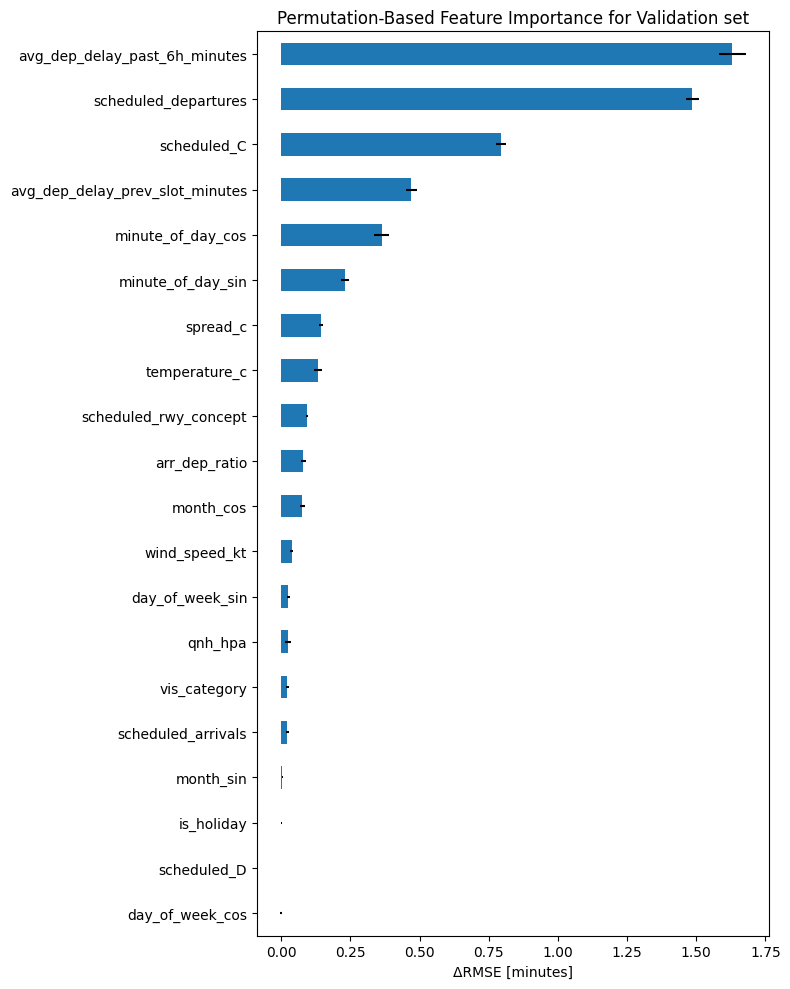

In [17]:
from sklearn.inspection import permutation_importance
import numpy as np
import matplotlib.pyplot as plt

# Ensure y is 1-D
y_val_1d = y_val.values.ravel()  # if y_val is a 1-col DataFrame

r = permutation_importance(
    model, X_val, y_val_1d,
    n_jobs=-1,
    n_repeats=100,
    random_state=42,
    scoring="neg_root_mean_squared_error"
)

# Build Series so indices align with feature names
imp_mean = pd.Series(r.importances_mean, index=X_val.columns).sort_values(ascending=False)
imp_std  = pd.Series(r.importances_std,  index=X_val.columns).reindex(imp_mean.index)

plt.figure(figsize=(8,10))
imp_mean.head(20).plot(
    kind="barh",
    xerr=imp_std.head(20).values  # pass values to xerr
)
plt.gca().invert_yaxis()
plt.xlabel("ΔRMSE [minutes]")
plt.title("Permutation-Based Feature Importance for Validation set")
plt.tight_layout()
plt.show()


Predicted vs Actual Delays Validaiton Set

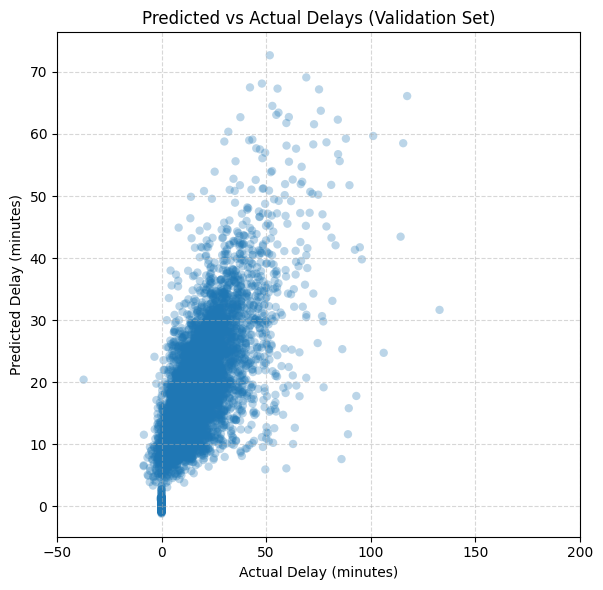

In [248]:
# Ensure Series alignment
y_true = y_val.squeeze()     # actual delays
y_pred = model.predict(X_val)

plt.figure(figsize=(6,6))
plt.scatter(y_true, y_pred, alpha=0.3, edgecolor='none')
plt.xlabel("Actual Delay (minutes)")
plt.ylabel("Predicted Delay (minutes)")
plt.title("Predicted vs Actual Delays (Validation Set)")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.xlim(-50, 200)
plt.show()


Residual Distribution (Residuals vs Predicted Delay)

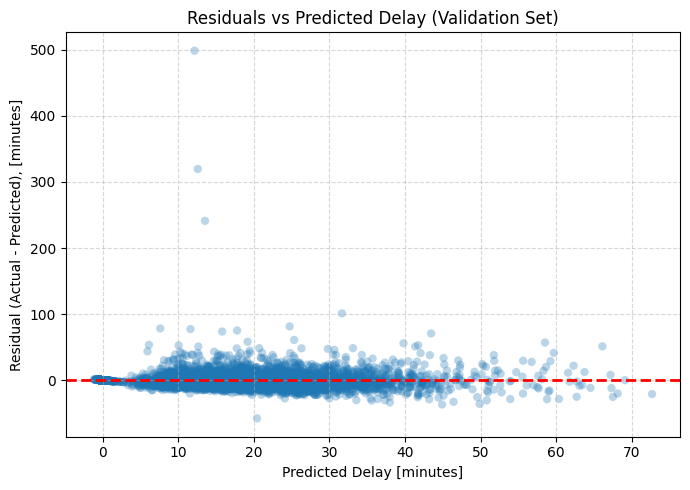

In [249]:
# Predicted and actual values
y_true = y_val.squeeze()
y_pred = model.predict(X_val)

# Residuals
residuals = y_true - y_pred

plt.figure(figsize=(7,5))
plt.scatter(y_pred, residuals, alpha=0.3, edgecolor='none')
plt.axhline(0, color="red", linestyle="--", lw=2)
plt.title("Residuals vs Predicted Delay (Validation Set)")
plt.xlabel("Predicted Delay [minutes]")
plt.ylabel("Residual (Actual - Predicted), [minutes]")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


Residual Distribution (Residuals vs Actual Delay)

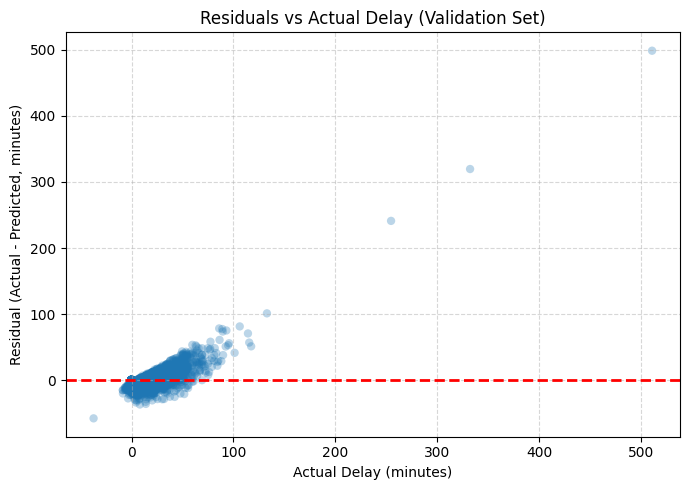

In [250]:
# 1) Make y_val a 1-D Series
y_true = y_val.squeeze()            # or: y_val.iloc[:, 0]

# 2) Make predictions and wrap in a Series with the same index
y_pred = pd.Series(model.predict(X_val), index=y_true.index)

# 3) Residuals
residuals = y_true - y_pred

# 4) Residuals vs ACTUAL plot
plt.figure(figsize=(7,5))
plt.scatter(y_true, residuals, alpha=0.3, edgecolor='none')
plt.axhline(0, color="red", linestyle="--", lw=2)
plt.title("Residuals vs Actual Delay (Validation Set)")
plt.xlabel("Actual Delay (minutes)")
plt.ylabel("Residual (Actual - Predicted, minutes)")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()
